### Taxi data analysis and computing Scalar function

#### Imports and Init

In [1]:
!pip install ripser
!pip install persim
!pip install pyshp
# !pip install kde-gpu

     |████████████████████████████████| 72 kB 253 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 47 kB 5.5 MB/s 
  Created wheel for ripser: filename=ripser-0.6.1-cp37-cp37m-linux_x86_64.whl size=455274 sha256=ef72062998fbd2ce0260c739044efc6108e2f9857fe303c1cd7c1be0c8460d60
  Stored in directory: /root/.cache/pip/wheels/6b/e3/c8/209a9df47cc9af8c6d2dbee4db558dc129494d3f4fbd670285
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18119 sha256=139e39e71c95b1d86212a500e1444b771226c10dd907d7ed0d7b1cf1753d1ca4
  Stored in directory: /root/.cache/pip/wheels/d2/9f/a8/67f1b86e47cd17338d3d07939f4660378e65b758c4594f96e3
Successfully built ripser hopcroftkarp
     |████████████████████████████████| 219 kB 5.4 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=bef21088cdebc5799f28084b8049af2d37dee5421

In [ ]:
# Use GPU runtime to import cupy by default
# KDE is not supported in cupy; Found this alternate library - https://pypi.org/project/kde-gpu/
# from kde_gpu import nadaraya_watson
# Try numba next

In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from scipy import stats

In [3]:
# import cupy as cp
from ripser import ripser, lower_star_img
from persim import plot_diagrams
from scipy import stats

In [4]:
from datetime import datetime

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from pathlib import Path

In [7]:
base_path = Path('/content/drive/Shareddrives/taxi_trends/')
os.chdir(base_path)
data_path = Path('Data/Taxi Data/')

#### Data Prep

In [8]:
taxidf = pd.read_csv(data_path / "yellow_tripdata_2018-10.csv")

In [9]:
taxidf.shape

(8821105, 17)

In [10]:
print(max(taxidf["tpep_pickup_datetime"]))
print(len(taxidf[taxidf["tpep_pickup_datetime"] > "2018-10-31"]), len(taxidf[taxidf["tpep_pickup_datetime"] < "2018-10-01"]))
# File has data after 2018 October as well

2020-08-01 00:20:58
273181 190


In [11]:
# Filter dataset for sample analysis
# Contains about 170k records for 5 days (2018 10 25 to 2018 10 31)
fil_ = (taxidf["tpep_pickup_datetime"] >= "2018-10-01") & (taxidf["tpep_pickup_datetime"] <= "2018-10-31")
taxidf = taxidf[fil_]

In [12]:
# Merge with Taxi zones to get lat/long
# Data sourced by using shape and dbf files 
taxi_zones = pd.read_csv(data_path / "taxi_zones_with_latlong.csv")
taxidf_ll = pd.DataFrame(taxidf).join(taxi_zones.set_index("LocationID"), on=["PULocationID"], how = "inner")
del(taxidf)
print(taxidf_ll.head())
print(taxidf_ll.shape)

     VendorID tpep_pickup_datetime  ...       lat       long
0           1  2018-10-01 00:23:34  ... -73.99994  40.748397
25          1  2018-10-01 00:22:18  ... -73.99994  40.748397
108         1  2018-10-01 00:09:33  ... -73.99994  40.748397
145         2  2018-10-01 00:02:51  ... -73.99994  40.748397
186         1  2018-10-01 00:32:47  ... -73.99994  40.748397

[5 rows x 24 columns]
(8403655, 24)


#### Calculating Scalar function using numpy

In [13]:
# Aggregating at hourly level
taxidf_ll.tpep_dropoff_datetime = pd.to_datetime(taxidf_ll.tpep_dropoff_datetime)

In [14]:
taxidf_ll.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone',
       'borough', 'lat', 'long'],
      dtype='object')

In [15]:
taxidf_ll["tpep_dropoff_date"] = taxidf_ll.tpep_dropoff_datetime.dt.date

In [16]:
taxidf_agg = taxidf_ll.groupby(by = ["lat", "long", "zone", "tpep_dropoff_date"], as_index=False)["DOLocationID"].count()

In [17]:
taxidf_agg.dtypes

lat                  float64
long                 float64
zone                  object
tpep_dropoff_date     object
DOLocationID           int64
dtype: object

In [18]:
taxidf_agg['tpep_dropoff_date'] = pd.to_datetime(taxidf_agg['tpep_dropoff_date'])

In [19]:
taxidf_agg['weekday'] = taxidf_agg.tpep_dropoff_date.dt.weekday

In [20]:
taxidf_agg.groupby(by = ['zone', 'weekday'], as_index=False)['DOLocationID'].mean()

,zone,weekday,DOLocationID
0,Allerton/Pelham Gardens,0,6.80
1,Allerton/Pelham Gardens,1,5.40
2,Allerton/Pelham Gardens,2,4.75
3,Allerton/Pelham Gardens,3,5.75
4,Allerton/Pelham Gardens,4,6.25
...,...,...,...
1743,Yorkville West,2,4058.80
1744,Yorkville West,3,5292.50
1745,Yorkville West,4,5885.25
1746,Yorkville West,5,6401.00


In [21]:
taxidf_weekday_avg = taxidf_agg.groupby(by = ['zone', 'weekday'], as_index=False)['DOLocationID'].mean()

In [22]:
taxidf_agg = taxidf_agg.merge(taxidf_weekday_avg, how='left', on=['zone', 'weekday'], suffixes=('', '_mean'))

In [23]:
taxidf_agg['dev_from_mean'] = taxidf_agg['DOLocationID']-taxidf_agg['DOLocationID_mean']

In [24]:
taxidf_agg = taxidf_agg[~(taxidf_agg['tpep_dropoff_date'].isin(['2018-09-20', '2018-10-31']))]

In [25]:
taxidf_agg.shape

(7111, 8)

In [26]:
import seaborn as sns
sns.set()
sns.set_palette('deep')

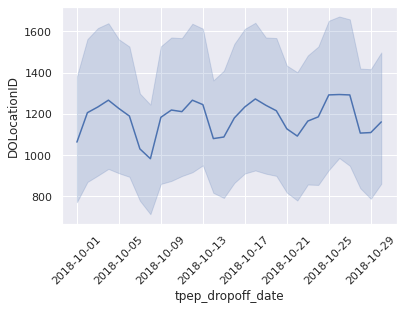

In [27]:
plt.xticks(rotation=45)
sns.lineplot(x=taxidf_agg['tpep_dropoff_date'], y=taxidf_agg['DOLocationID'])

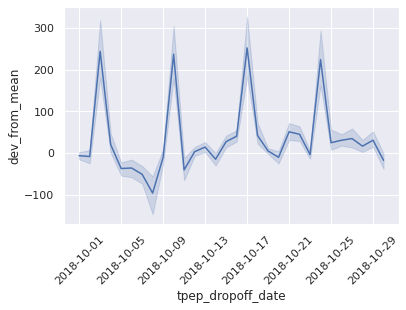

In [28]:
plt.xticks(rotation=45)
sns.lineplot(x=taxidf_agg['tpep_dropoff_date'], y=taxidf_agg['dev_from_mean'])

In [29]:
taxidf_agg.head()

,lat,long,zone,tpep_dropoff_date,DOLocationID,weekday,DOLocationID_mean,dev_from_mean
0,-74.229547,40.527298,Charleston/Tottenville,2018-10-11,2,3,2.0,0.0
1,-74.206973,40.540743,Rossville/Woodrow,2018-10-16,1,1,1.0,0.0
2,-74.189930,40.550340,Arden Heights,2018-10-01,1,0,1.0,0.0
3,-74.189930,40.550340,Arden Heights,2018-10-02,2,1,1.2,0.8
4,-74.189930,40.550340,Arden Heights,2018-10-03,1,2,1.0,0.0


for date: 2018-10-25; nrecords: 234
[1 3] [[ 0.66936338  0.72149104]
 [ 0.9891417   1.1919837 ]
 [18.0828476  18.10542679]
 [29.8093586          inf]]
5653 [[1.03223438 1.04375178 1.05744695 ... 0.99354517 0.99306178 0.99263651]
 [1.0469492  1.06208502 1.07998717 ... 0.99617431 0.99545832 0.99481147]
 [1.06505361 1.08451932 1.10741994 ... 1.00026226 0.99919684 0.99821255]
 ...
 [1.77994188 1.81062699 1.83631347 ... 0.9891417  0.9891417  0.9891417 ]
 [1.79627378 1.82186287 1.84170831 ... 0.9891417  0.9891417  0.9891417 ]
 [1.79511069 1.81514846 1.82892123 ... 0.9891417  0.9891417  0.9891417 ]]
Event in: 2018-10-25 -- (40.73745662, -74.18992967)
5653 [[29.85245128 29.86396867 29.87766385 ... 29.81376207 29.81327868
  29.8128534 ]
 [29.86716609 29.88230191 29.90020407 ... 29.81639121 29.81567522
  29.81502836]
 [29.88527051 29.90473622 29.92763684 ... 29.82047916 29.81941373
  29.81842945]
 ...
 [30.60015877 30.63084388 30.65653037 ... 29.8093586  29.8093586
  29.8093586 ]
 [30.61649068 3

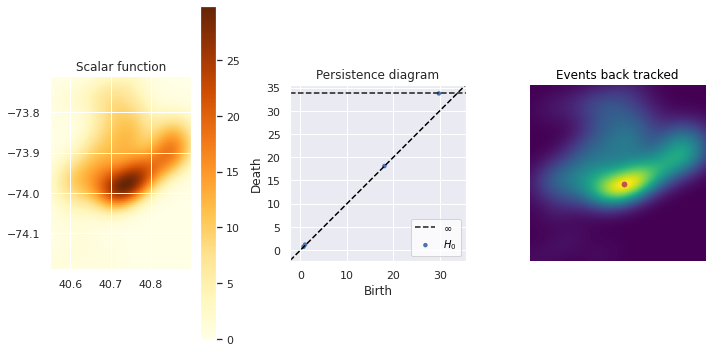

In [30]:
dates = ['2018-10-25'] #, '2018-10-26', '2018-10-27', '2018-10-28', '2018-10-29', '2018-10-30', '2018-10-31'

# date = '2018-10-25'

plt.figure(figsize=(10, 5))

for date in dates:
  taxidf_agg_sub = taxidf_agg[taxidf_agg['tpep_dropoff_date'] == date]
  print(f'for date: {date}; nrecords: {taxidf_agg_sub.shape[0]}')
  # Convert to numpy arrays
  m1 = taxidf_agg_sub[['lat','long']].to_numpy()[:,1]
  m2 = taxidf_agg_sub[['lat','long']].to_numpy()[:,0]
  xmin = m1.min()
  xmax = m1.max()
  ymin = m2.min()
  ymax = m2.max()

  X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
  positions = np.vstack([X.ravel(), Y.ravel()])
  values = np.vstack([m1, m2])
  # Applying guassian kernel
  kernel = stats.gaussian_kde(values)
  Z = np.reshape(kernel(positions).T, X.shape)
  scalar = np.rot90(Z)

  dgm = lower_star_img(-Z)
  dgm[~np.isinf(dgm)] = -dgm[~np.isinf(dgm)]
  dgm[~np.isinf(dgm).any(axis=1)] = np.flip(dgm[~np.isinf(dgm).any(axis=1)])

  plt.subplot(131)
  plt.imshow(scalar, cmap=plt.cm.YlOrBr, extent=[xmin, xmax, ymin, ymax])
  plt.colorbar()
  plt.title("Scalar function")
  plt.subplot(132)
  plot_diagrams(dgm)
  plt.title("Persistence diagram")
  plt.tight_layout()

  thresh = 0.1
  idxs = np.arange(dgm.shape[0])
  idxs = idxs[np.abs(dgm[:, 1] - dgm[:, 0]) > thresh]
  print(idxs, dgm)

  X_1, Y_1 = np.meshgrid(np.arange(scalar.shape[1]), np.arange(scalar.shape[0]))
  X_1 = X_1.flatten()
  Y_1 = Y_1.flatten()

  plt.subplot(133)
  plt.imshow(scalar)

  for idx in idxs:
    bidx = np.argmax(np.abs(scalar + dgm[idx, 0]))
    print(bidx, abs(scalar + dgm[idx, 0]))
    plt.scatter(X_1[bidx], Y_1[bidx], 20, 'r')
    plt.title("Events back tracked")
    print(f'Event in: {date} -- {X[X_1[bidx]][0], Y[Y_1[bidx]][0]}')

  plt.axis('off')
  plt.show()

[3] [[ 0.66936338  0.72149104]
 [ 0.9891417   1.1919837 ]
 [18.0828476  18.10542679]
 [29.8093586          inf]]
5653
Event in: (40.73745662, -74.18992967)


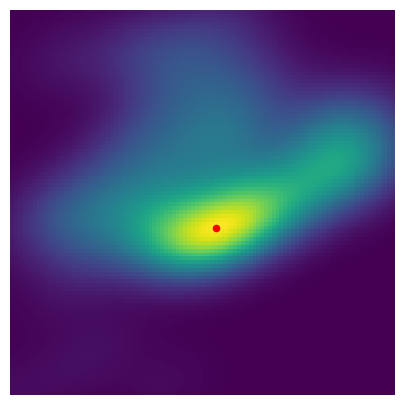

In [ ]:
|